In [ ]:
# Building a Clash Detection Model

## Import Required libraries and Data

In [1]:
#check

In [23]:
#import required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
from joblib import dump
from sklearn.model_selection import RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
import scipy.stats as stats
import pylab as pl
warnings.filterwarnings("ignore")

In [24]:
#Load Data
d1=pd.read_excel(
     os.path.join("/Users/nikhilr/Desktop/thesis/Data and Code/Model", "NCC MEP MEP CD Basic.xlsx"),
     engine='openpyxl',
)
d2=pd.read_excel(
     os.path.join("/Users/nikhilr/Desktop/thesis/Data and Code/Model", "NCC ARC STR CD Basic.xlsx"),
     engine='openpyxl',
)

d3=pd.read_excel(
     os.path.join("/Users/nikhilr/Desktop/thesis/Data and Code/Model", "NCC MEP STR CD Basic SO1.xlsx"),
     engine='openpyxl',
)
frames = [d1,d2,d3]
data = pd.concat(frames)


In [25]:
print(data.shape)
data.dropna(axis = 0, how ='any')
print(data.shape)


(3824, 15)
(3824, 15)


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3824 entries, 0 to 488
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0    Number            3821 non-null   float64       
 1   ID                 3821 non-null   float64       
 2   GUID               3821 non-null   object        
 3   Location           3814 non-null   object        
 4   Date               3821 non-null   datetime64[ns]
 5   Author             3821 non-null   object        
 6   Picture            0 non-null      float64       
 7   Issue Description  3821 non-null   object        
 8   Issue comment      0 non-null      float64       
 9   Responsibilities   0 non-null      float64       
 10  Discipline         3821 non-null   float64       
 11  Labels             0 non-null      float64       
 12  Status             3821 non-null   object        
 13  Issue Type         3821 non-null   object        
 14  Phase    

## Data Preprocessing

In [74]:
#Function to clean the data 
def prepare_data(df1):
    try:
        if "Issue Description" in df1:
            df = []
            df = pd.DataFrame(df)
            
            #split the data value columns in issue description
            new = df1["Issue Description"].str.split(":", n = 1, expand = True) 
            df1["required"]= new[1]
    
            #Split the above required column 
            new = df1["required"].str.split(",", n = 5, expand = True) 
            df1["component1"]= new[0] 
            df1["component2"]= new[1]
            df1["x"]= new[2]
            df1["y"]= new[3]
            df1["z"]= new[4]
            df1["volume"]= new[5]
            
            #new dataframe with split values in component1 columns
            new = df1["component1"].str.split(".", n = 1, expand = True) 
            df1['comp1'] = new[0]
            df1['distance1'] = new[1]
            
            #new dataframe with split values in distance columns
            new = df1["distance1"].str.split(".", n = 2, expand = True) 
            df1['distance_1'] = new[0]
            df1['distance1_2'] = new[1]
            df1['distance'] = df1['distance_1'].str.cat(df1['distance1_2'], sep =".") 

            #new dataframe with split values in component2 columns
            new = df1["component2"].str.split(".", n = 1, expand = True) 
            df1['comp2'] = new[0]
            df1['distance2'] = new[1]
            
            #X_axis data extract withour the measure
            new = df1["x"].str.split("m", n = 1, expand = True) 
            df1['x_axis'] = new[0]
            
            #y_axis data extract withour the measure
            new = df1["y"].str.split("m", n = 1, expand = True) 
            df1['y_axis'] = new[0]
            
            #z_axis data extract withour the measure
            new = df1["z"].str.split("m", n = 1, expand = True) 
            df1['z_axis'] = new[0] 
            
            #Volume extract without the measure
            new = df1["volume"].str.split("m", n = 1, expand = True) 
            df1['v'] = new[0]
            
            #Extract the first clashed componenet
            new = df1["comp1"].str.split("\n", n = 1, expand = True) 
            df1['component1'] = new[1]
            
            #Extract the volume
            new = df1["v"].str.split(",", n = 1, expand = True) 
            df1['vol'] = new[1]
            
            #to seperate the component 1 and discipline 1
            new = df1["component1"].str.split("(", n = 1, expand = True) 
            df1['empty1'] = new[0]
            df1['dis1'] = new[1]
            new = df1["dis1"].str.split(")", n = 1, expand = True) 
            df1['discipline1'] = new[0]
            df1['component1'] = new[1]
            
            #to seperate the component 2 and discipline 2
            new = df1["comp2"].str.split("(", n = 1, expand = True) 
            df1['empty'] = new[0]
            df1['dis'] = new[1]
            new = df1["dis"].str.split(")", n = 1, expand = True) 
            df1['discipline2'] = new[0]
            df1['component2'] = new[1]
            
            #Keep only required column in the new dataframe as df and convert the column datatype to numeric
            if "x_axis" in df1:
                df["x_axis"] = pd.to_numeric(df1["x_axis"])
                if "y_axis" in df1:
                    df["y_axis"] = pd.to_numeric(df1["y_axis"])
                    if "z_axis" in df1:
                        df["z_axis"] = pd.to_numeric(df1["z_axis"])
                        if "vol" in df1:
                            df["vol"] = pd.to_numeric(df1["vol"])
                            if "distance2" in df1:
                                df["distance2"] = pd.to_numeric(df1["distance2"])
                                if "distance1" in df1:
                                    df["distance1"] = pd.to_numeric(df1["distance"])
            #feature engineering for ID column 
            df1["Dupli"] = df1.ID.duplicated(keep=False)
            #Encode the values that are not numbers
            #categorical column is encoded using cat.code function.

            df["Status_cat"] = df1.Status.astype('category').cat.codes
            df["Location_cat"] = df1.Location.astype('category').cat.codes
            df["component2_cat"] = df1.component2.astype('category').cat.codes
            df["component1_cat"] = df1.component1.astype('category').cat.codes
            df["discipline1_cat"] = df1.discipline2.astype('category').cat.codes
            df["discipline2_cat"] = df1.discipline2.astype('category').cat.codes
            df["Clash<1"] = df1.Dupli.astype('category').cat.codes
            df["ID"] = df1["ID"]
            df['Phase'] = 1
            df = df.dropna(axis = 0, how ='any')
            return df
    except Exception as e:
        print(e)

In [75]:
df = prepare_data(data)

# Data Visualization

### Distribution of data

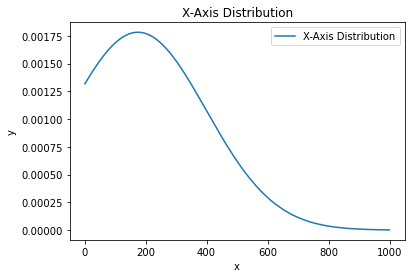

In [97]:
#Distribution  of x axis 
h = list(df.x_axis)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X-Axis Distribution")
plt.legend(["X-Axis Distribution"])

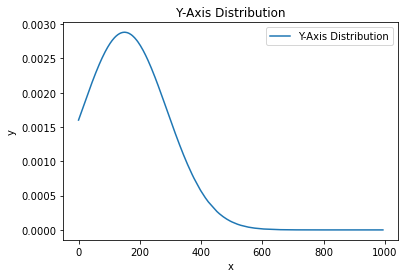

In [98]:
#Distribution  of x axis 
h = list(df.y_axis)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Y-Axis Distribution")
plt.legend(["Y-Axis Distribution"])

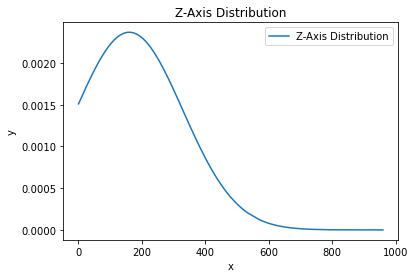

In [99]:
#Distribution  of x axis 
h = list(df.z_axis)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Z-Axis Distribution")
plt.legend(["Z-Axis Distribution"])

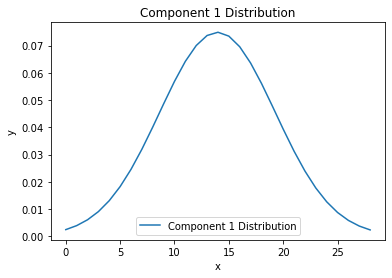

In [100]:
#Distribution of component 1
h = list(df.component1_cat)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Component 1 Distribution")
plt.legend(["Component 1 Distribution"])

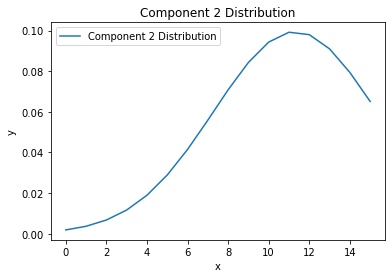

In [101]:
#Distribution of component 2
h = list(df.component2_cat)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Component 2 Distribution")
plt.legend(["Component 2 Distribution"])

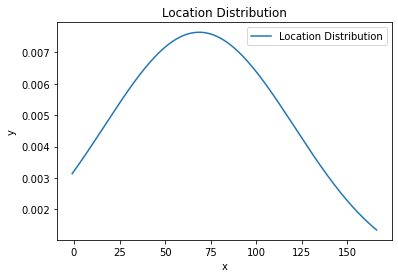

In [102]:
#LOcation distribution 
h = list(df.Location_cat)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Location Distribution")
plt.legend(["Location Distribution"])

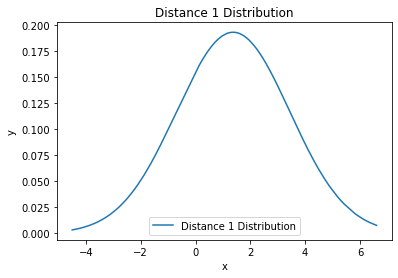

In [103]:
#Distance 1 distribution
h = list(df.distance1)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distance 1 Distribution")
plt.legend(["Distance 1 Distribution"])

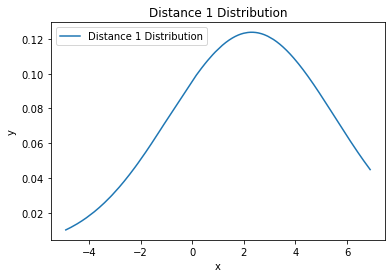

In [104]:
#Distance 2 Distribution
h = list(df.distance2)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distance 1 Distribution")
plt.legend(["Distance 1 Distribution"])

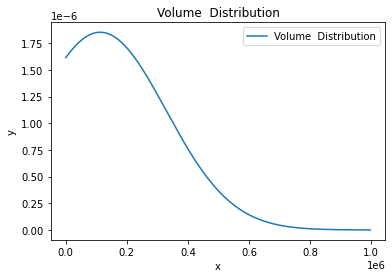

In [105]:
#Volume Distribution
h = list(df.vol)
h.sort()
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Volume  Distribution")
plt.legend(["Volume  Distribution"])

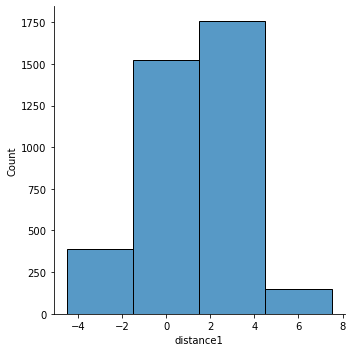

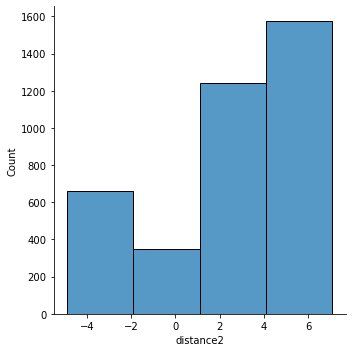

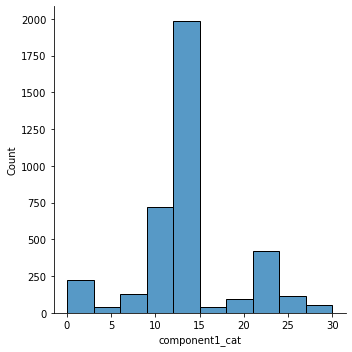

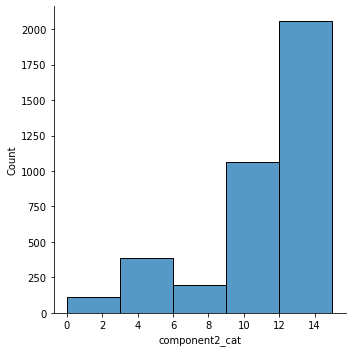

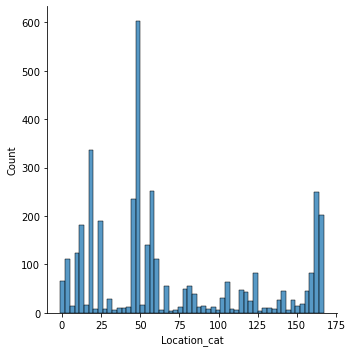

In [107]:
sns.displot(df, x="distance1", binwidth=3)
sns.displot(df, x="distance2", binwidth=3)
sns.displot(df, x="component1_cat", binwidth=3)
sns.displot(df, x="component2_cat", binwidth=3)
sns.displot(df, x="Location_cat", binwidth=3)

<AxesSubplot:xlabel='Status_cat', ylabel='count'>

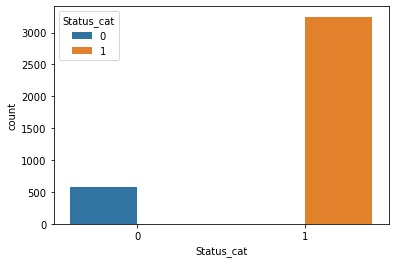

In [45]:
# 0 means open and 1 means resolved for status column
#Number of open and Resolved count for status plot
sns.countplot(x="Status_cat",hue="Status_cat", data=df)

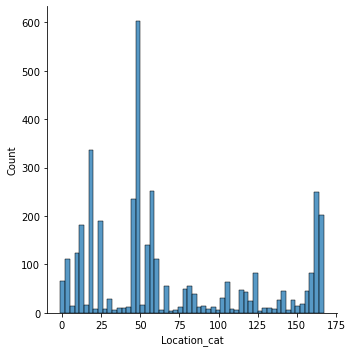

In [6]:
#Location dis plot
sns.displot(df, x="Location_cat", binwidth=3)

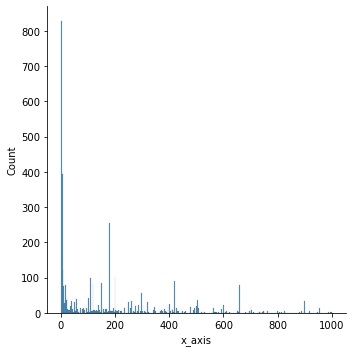

In [7]:
#Location x_axis plot
sns.displot(df, x="x_axis", binwidth=3)

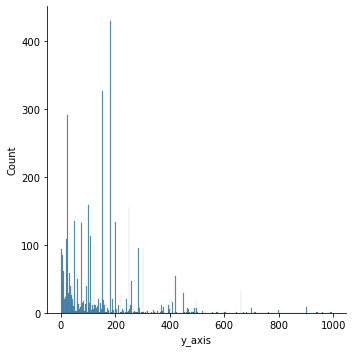

In [8]:
#Location y_axis plot
sns.displot(df, x="y_axis", binwidth=3)

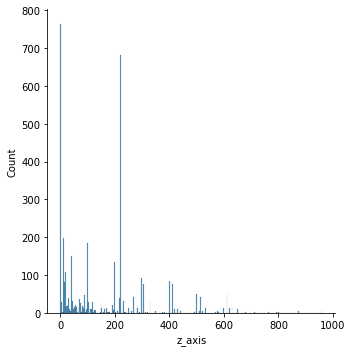

In [9]:
#Location z_axis plot
sns.displot(df, x="z_axis", binwidth=3)

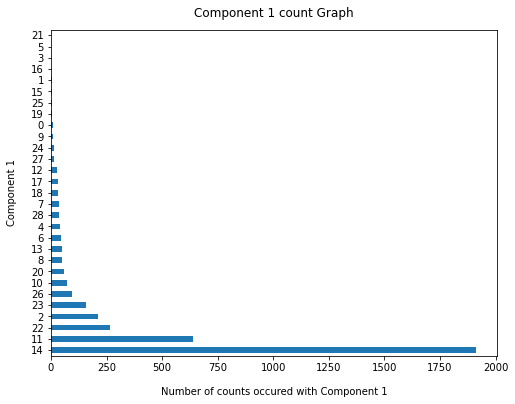

In [10]:
# Componenet 1 count graph
df['component1_cat'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of counts occured with Component 1", labelpad=14)
plt.ylabel("Component 1", labelpad=14)
plt.title("Component 1 count Graph", y=1.02);

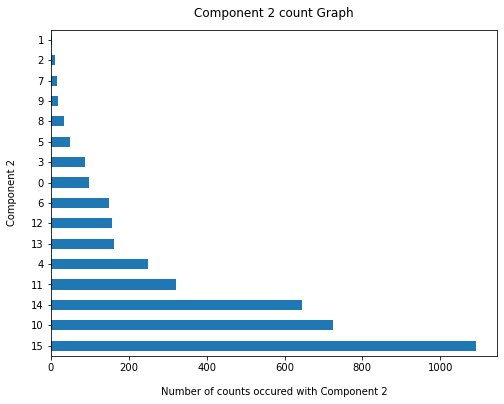

In [11]:
# Componenet 2 count graph
df['component2_cat'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of counts occured with Component 2", labelpad=14)
plt.ylabel("Component 2", labelpad=14)
plt.title("Component 2 count Graph", y=1.02);

<AxesSubplot:xlabel='component1_cat', ylabel='count'>

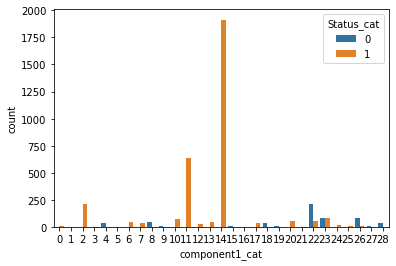

In [12]:
#Number of count for Component1
sns.countplot(x="component1_cat",hue="Status_cat", data=df)

<AxesSubplot:xlabel='component2_cat', ylabel='count'>

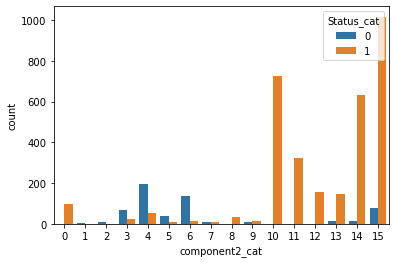

In [13]:
#Number of count for Component2
sns.countplot(x="component2_cat",hue="Status_cat", data=df)

<AxesSubplot:xlabel='Discipline', ylabel='count'>

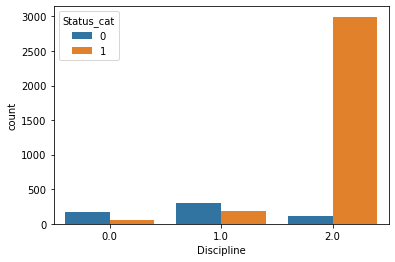

In [14]:
#Number of count for Discipline
sns.countplot(x="Discipline",hue="Status_cat", data=df)

In [15]:
df.head()

,x_axis,y_axis,z_axis,vol,distance2,distance1,Status_cat,Location_cat,component2_cat,component1_cat,dup_cat,ID,Discipline,Phase
0,172.0,43.0,12.0,51.0,-1.800,1.410,1,142,8,18,0,11631.0,0.0,1
1,60.0,50.0,200.0,600.0,-1.750,-1.300,1,161,8,17,0,11632.0,0.0,1
2,60.0,50.0,200.0,600.0,-1.750,-1.400,1,161,8,17,0,11633.0,0.0,1
3,500.0,35.0,33.0,442.0,-2.230,-2.277,0,164,6,18,0,11634.0,0.0,1
4,400.0,22.0,10.0,71.0,3.301,3.370,0,122,6,18,0,11635.0,0.0,1


## Model Selection

In [79]:
#split x and y data
x=df.drop(["Status_cat"],axis=1)
y=df["Status_cat"]

#define all the models in a  list to apply cross validation
models = [LogisticRegression(),DecisionTreeClassifier(),
          GradientBoostingClassifier(),RandomForestClassifier()]
#Test size
size = [0.2,0.3,0.4]

In [80]:
#function to find a better suited model 
def find_model(models,size,x,y):
    for j in size:
        #split data into train and test with 70 and 30 ratio
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=j)
        for i in models:
            #Logistic Regression Model
            model =  i.fit(x_train,y_train)
            lr_pred = model.predict(x_test)
            prob = model.predict_proba(x_test)
            #classification Report  
            print("classification Report for ",i, "with train/test size ",j*100,"/",100-(j*100),
                  "\n"+classification_report(y_test,lr_pred))

In [81]:
#call find model function
find_model(models,size,x,y)

classification Report for  LogisticRegression() with train/test size  20.0 / 80.0 
              precision    recall  f1-score   support

           0       0.63      0.73      0.67       118
           1       0.95      0.92      0.93       646

    accuracy                           0.89       764
   macro avg       0.79      0.82      0.80       764
weighted avg       0.90      0.89      0.89       764

classification Report for  DecisionTreeClassifier() with train/test size  20.0 / 80.0 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       118
           1       1.00      0.99      1.00       646

    accuracy                           0.99       764
   macro avg       0.98      0.99      0.99       764
weighted avg       0.99      0.99      0.99       764

classification Report for  GradientBoostingClassifier() with train/test size  20.0 / 80.0 
              precision    recall  f1-score   support

           0       0.97      0

### Apply Cross validation

In [82]:
#10 fold cross validation is applied to find out the performance of the model
for i in models:
    scores = cross_val_score(i, x, y, cv=10)
    print("10 fold Cross validation Average Accuracy for ",i,"is",scores.mean()*100,"\n")

10 fold Cross validation Average Accuracy for  LogisticRegression() is 87.52621236481565 

10 fold Cross validation Average Accuracy for  DecisionTreeClassifier() is 81.26959915350895 

10 fold Cross validation Average Accuracy for  GradientBoostingClassifier() is 80.95127179783155 

10 fold Cross validation Average Accuracy for  RandomForestClassifier() is 81.26582017561941 



### ROC Metrics

LogisticRegression()
 Model ROC


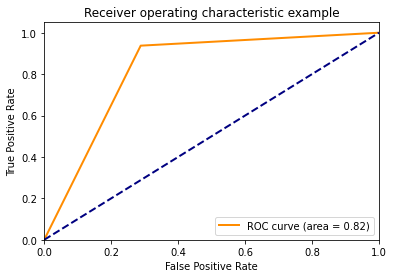

DecisionTreeClassifier()
 Model ROC


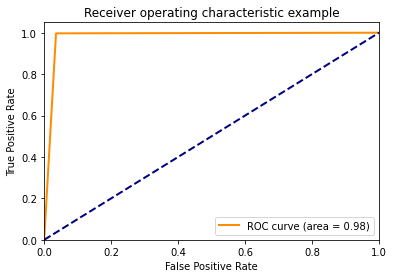

GradientBoostingClassifier()
 Model ROC


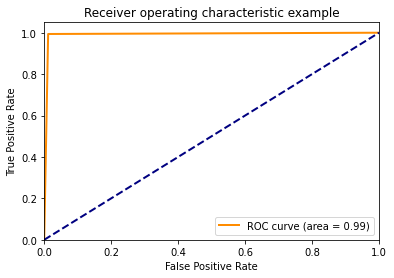

RandomForestClassifier()
 Model ROC


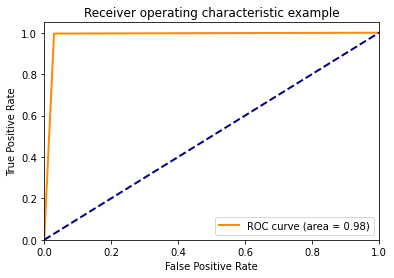

In [83]:
#ROC is ploted to find out the performance of the model
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
for i in models:
    print(i)
    print(" Model ROC")
    n_classes = 2
    classifier =  i
    y_score = classifier.fit(x_train,y_train).predict(x_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [35]:
# set random seed for reproducibility
seed(42)

model = Sequential()
lyrs = [8]
# create first hidden layer
model.add(Dense(lyrs[0], input_dim=x_train.shape[1], activation='linear'))
lyrs = [8]
# create additional hidden layers
for i in range(1,len(lyrs)):
    model.add(Dense(lyrs[i], activation='linear'))

# add dropout, default is none
model.add(Dropout(0.0))

# create output layer
model.add(Dense(1, activation='sigmoid'))  # output layer

#Compile
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
# train model on full train set, with 80/20 CV split
model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)

In [36]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 128       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
loss, acc = model.evaluate(x_test, y_test)
print("loss: %s, accuracy: %s" % (loss, acc))

36/36 [==============================] - 0s 2ms/step - loss: 35.2268 - accuracy: 0.8883
loss: 35.22677230834961, accuracy: 0.8883071541786194


In [38]:
y_predict = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [39]:
#classification Report  
print("classification Report for"+classification_report(y_test,y_predict))

classification Report for              precision    recall  f1-score   support

           0       0.61      0.66      0.63       169
           1       0.94      0.93      0.93       977

    accuracy                           0.89      1146
   macro avg       0.78      0.79      0.78      1146
weighted avg       0.89      0.89      0.89      1146



### Fine tune model

In [27]:
#Gradient Boost
param_dist = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],'max_depth':range(1,10),'min_samples_split':range(1,10),'min_samples_leaf':range(1,10), 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

# Instantiating RandomizedSearchCV object 
gbc_cv = RandomizedSearchCV(GradientBoostingClassifier(max_features='sqrt', random_state=10), param_dist, cv = 10)
gbc_cv.fit(x_train, y_train)

# Print the tuned parameters and score 
print("Tuned Gradient Boosting Classifier Parameters: {}".format(gbc_cv.best_params_)) 
print("Best score is {}".format(gbc_cv.best_score_))

Tuned Gradient Boosting Classifier Parameters: {'n_estimators': 750, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.05}
Best score is 0.9962602716753313


In [28]:
#Random Forest
param_dist = {'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_features':['sqrt', 'log2'],}

# Instantiating RandomizedSearchCV object 
rf_cv = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv = 10)
rf_cv.fit(x_train, y_train)

# Print the tuned parameters and score 
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_)) 
print("Best score is {}".format(rf_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 1000, 'max_features': 'log2'}
Best score is 0.9943876124993013


In [29]:
#Decision Tree using RandomizedSearchCV

# Creating the hyperparameter grid  
param_dist = {
    "criterion":['gini','entropy'],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,5)
}
# Instantiating Decision Tree classifier 
tree = DecisionTreeClassifier() 
  
# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 10)
tree_cv.fit(x_train, y_train)

# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 8, 'criterion': 'gini'}
Best score is 0.9861521046453126


In [30]:
x_test.shape

(1146, 13)


### Save the model 

In [84]:
# loading the trained model  
# Save the model as a pickle in a file 
clf = GradientBoostingClassifier(subsample= 1, n_estimators= 1000, min_samples_split= 3, min_samples_leaf= 9, max_depth= 5, learning_rate= 0.01)
clf.fit(x_train,y_train)
dump(clf, 'clf.joblib')
#--
#Load the model
#from joblib import load
#clf = load('clf.joblib')

['clf.joblib']

In [85]:
clf.feature_importances_

array([4.17455530e-02, 1.29798914e-03, 1.01244133e-02, 3.53458606e-03,
       7.96449193e-03, 6.35652306e-02, 1.03916608e-03, 1.58407564e-01,
       6.72005134e-02, 5.65464650e-04, 3.26111909e-04, 0.00000000e+00,
       6.44228916e-01, 0.00000000e+00])

In [86]:
#Save Model
import pickle
filename='Model.sav'
pickle.dump(clf, open(filename, 'wb'))

## NCC MODEL OUTPUT

In [45]:
# Load the model from the file 
#Load Model
import pickle
filename='Model.sav'
clf =pickle.load(open(filename, 'rb'))

In [118]:
#Function to clean the data 
def pred(df1):
    try:
        if "Issue Description" in df1:
            df = []
            df = pd.DataFrame(df)
            
            #split the data value columns in issue description
            new = df1["Issue Description"].str.split(":", n = 1, expand = True) 
            df1["required"]= new[1]
    
            #Split the above required column 
            new = df1["required"].str.split(",", n = 5, expand = True) 
            df1["component1"]= new[0] 
            df1["component2"]= new[1]
            df1["x"]= new[2]
            df1["y"]= new[3]
            df1["z"]= new[4]
            df1["volume"]= new[5]
            
            #new dataframe with split values in component1 columns
            new = df1["component1"].str.split(".", n = 1, expand = True) 
            df1['comp1'] = new[0]
            df1['distance1'] = new[1]
            
            #new dataframe with split values in distance columns
            new = df1["distance1"].str.split(".", n = 2, expand = True) 
            df1['distance_1'] = new[0]
            df1['distance1_2'] = new[1]
            df1['distance'] = df1['distance_1'].str.cat(df1['distance1_2'], sep =".") 

            #new dataframe with split values in component2 columns
            new = df1["component2"].str.split(".", n = 1, expand = True) 
            df1['comp2'] = new[0]
            df1['distance2'] = new[1]
            
            #X_axis data extract withour the measure
            new = df1["x"].str.split("m", n = 1, expand = True) 
            df1['x_axis'] = new[0]
            
            #y_axis data extract withour the measure
            new = df1["y"].str.split("m", n = 1, expand = True) 
            df1['y_axis'] = new[0]
            
            #z_axis data extract withour the measure
            new = df1["z"].str.split("m", n = 1, expand = True) 
            df1['z_axis'] = new[0] 
            
            #Volume extract without the measure
            new = df1["volume"].str.split("m", n = 1, expand = True) 
            df1['v'] = new[0]
            
            #Extract the first clashed componenet
            new = df1["comp1"].str.split("\n", n = 1, expand = True) 
            df1['component1'] = new[1]
            
            #Extract the volume
            new = df1["v"].str.split(",", n = 1, expand = True) 
            df1['vol'] = new[1]
            
            #to seperate the component 1 and discipline 1
            new = df1["component1"].str.split("(", n = 1, expand = True) 
            df1['empty1'] = new[0]
            df1['dis1'] = new[1]
            new = df1["dis1"].str.split(")", n = 1, expand = True) 
            df1['discipline1'] = new[0]
            df1['component1'] = new[1]
            
            #to seperate the component 2 and discipline 2
            new = df1["comp2"].str.split("(", n = 1, expand = True) 
            df1['empty'] = new[0]
            df1['dis'] = new[1]
            new = df1["dis"].str.split(")", n = 1, expand = True) 
            df1['discipline2'] = new[0]
            df1['component2'] = new[1]
            
            #Keep only required column in the new dataframe as df and convert the column datatype to numeric
            if "x_axis" in df1:
                df["x_axis"] = pd.to_numeric(df1["x_axis"])
                if "y_axis" in df1:
                    df["y_axis"] = pd.to_numeric(df1["y_axis"])
                    if "z_axis" in df1:
                        df["z_axis"] = pd.to_numeric(df1["z_axis"])
                        if "vol" in df1:
                            df["vol"] = pd.to_numeric(df1["vol"])
                            if "distance2" in df1:
                                df["distance2"] = pd.to_numeric(df1["distance2"])
                                if "distance1" in df1:
                                    df["distance1"] = pd.to_numeric(df1["distance"])
            #feature engineering for ID column 
            df1["Dupli"] = df1.ID.duplicated(keep=False)
            #Encode the values that are not numbers
            #categorical column is encoded using cat.code function.
            df["Location"] = df1.Location
            df["component2"] = df1.component2
            df["component1"] = df1.component1
            df["discipline1"] = df1.discipline2
            df["discipline2"] = df1.discipline2
            df["Clash<1"] = df1.Dupli.astype('category').cat.codes
            df["ID"] = df1["ID"]
            #Adding phase feature
            if phase == "Tender":
                df["phase"] = 0
            elif phase == "Design":
                df["phase"] = 1
            elif phase == "Production":
                df["phase"] = 2
            df["GUID"]=df1["GUID"]
            df = df.dropna(axis = 0, how ='any')
            return df
    except Exception as e:
        print(e)

In [119]:
def cat_encode(df):
    df["Location"] = df.Location.astype('category').cat.codes
    df["component2"] = df.component2.astype('category').cat.codes
    df["component1"] = df.component1.astype('category').cat.codes
    df["discipline1"] = df.discipline2.astype('category').cat.codes
    df["discipline2"] = df.discipline2.astype('category').cat.codes
    return df
data_preprocessed = pred(data)
data_check = data_preprocessed.copy()
data_encode = cat_encode(data_preprocessed)
data_encode=data_encode.drop(["GUID"],axis=1)
# # Making predictions 
d = clf.predict(data_encode)
proba = clf.predict_proba(data_encode)
data_check["Predict"] = d
p = pd.DataFrame(proba, columns = ['proba_0','proba_1'])
p = p * 100
data_check["Non-Pseudo Clash Probability"] = p.proba_0
data_check["Pseudo Clash Probability"] = p.proba_1